# 25-Relief Action

Learning Objectives:
- Use orifice flow estimates in mass and energy balance calculations
- Estimate vent sizing for deflagrations
- Gain experience with mass and energy balance principles
- Review relief requirements for fire scenarios


Review of MAWP and max accumulation pressure or max overpressure (based on gauge pressure)

## Orifice Flow and Mass Balances

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

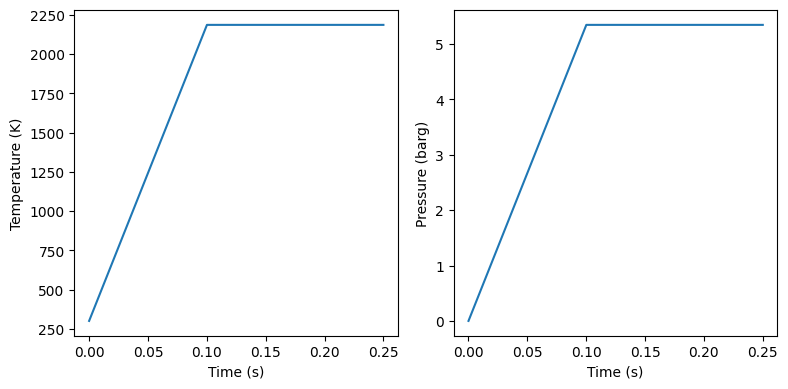

In [35]:
{
    "tags": [
        "hide-input",
    ]
}

#first scenario with 20 liter sphere with methane and air
#     assume constant burn rate
#     3 moles (CH4 and 2O2) react to yield 3 moles (CO2 and 2H2O) thus dn/dt = in - out + gen = 0

k = 15 #moles/sec/m3, estimate of reaction rate of methane and air, assumed constant burn rate
tburn = 0.1 #seconds, time to burn 20 liters of methane (rough estimate only)
V = 20/1000 #20 liter sphere to m^3
DH_rx = 890.4*1000 #J/mol CH4 , heat of combustion
Tinitial = 300 #K, initial temperature of sphere
Pinitial = 85000 #Pa, initial pressure of sphere
Rg = 8.314 #J/mol*K, ideal gas constant
n = Pinitial*V/(Rg*Tinitial) #moles of gas in sphere
Cv = 5/2*Rg #J/mol*K, heat capacity at constant volume (estimate for gases)

#energy balance: d(nU)/dt = gen = kV DH_rx 

def derivatives(var, time):
    T = var
    if time < tburn:
        dTdt = k*V*DH_rx/(n*Cv)
    else:
        dTdt = 0
    return dTdt

time = np.linspace(0, 0.25, 1000)
T = odeint(derivatives, Tinitial, time).T[0]
P = n*Rg*T/V

#plot temperature and pressure in two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(time, T)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Temperature (K)')
ax[1].plot(time, P/1e5 - Pinitial/1e5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Pressure (barg)')
plt.tight_layout()
plt.show()



See this reference for more detailed information on combustion of methane in a 20L and larger spheres: https://doi.org/10.1016/j.jlp.2017.02.022 